# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bookdata.db import db_url

## Load Link Stats

The `integration_stats` table in the database contains link success statistics in our data.

In [3]:
link_stats = pd.read_sql_table('integration_stats', db_url())
link_stats.head()

,dataset,source,gender,n_books,n_actions
0,LOC-MDS,VIAF,no-book-author,842755,NaN
1,LOC-MDS,VIAF,female,664221,NaN
2,LOC-MDS,VIAF,unknown,1214597,NaN
3,LOC-MDS,VIAF,ambiguous,53232,NaN
4,LOC-MDS,VIAF,no-author-rec,297405,NaN


Let's create lists for our different codes, in order, for later handling.  We'll start with the resolved codes:

In [4]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [5]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot(index=['dataset', 'source'], columns='gender', values='n_books')
book_counts = book_counts.reindex(columns=link_codes + unlink_codes)
book_counts

gender            female       male  ambiguous    unknown  no-author-rec  \
dataset source                                                             
AZ      VIAF    215556.0   480628.0    17056.0   236219.0       157072.0   
BX-E    VIAF     38093.0    55906.0     4014.0    16900.0         7627.0   
BX-I    VIAF     67087.0    96933.0     6770.0    34614.0        15631.0   
GR-E    LOC      17517.0    22096.0       66.0        NaN       182952.0   
        VIAF    174996.0   276045.0    11087.0    95887.0        35267.0   
GR-I    LOC      17657.0    22253.0       67.0        NaN       185750.0   
        VIAF    176640.0   279442.0    11189.0    97667.0        36106.0   
LOC-MDS LOC      39926.0    83321.0      184.0        NaN      1906805.0   
        VIAF    664221.0  2195117.0    53232.0  1214597.0       297405.0   

gender          no-book-author    no-book  
dataset source                             
AZ      VIAF          151817.0  1009794.0  
BX-E    VIAF            6447.0    22683.0  
BX-I    VIAF           12890.0    45576.0  
GR-E    LOC           487495.0        NaN  
        VIAF          487495.0        NaN  
GR-I    LOC           495592.0        NaN  
        VIAF          495592.0        NaN  
LOC-MDS LOC           842755.0        NaN  
        VIAF          842755.0        NaN

In [7]:
act_counts = link_stats.pivot(index=['dataset', 'source'], columns='gender', values='n_actions')
act_counts = act_counts.reindex(columns=link_codes + unlink_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender              female        male   ambiguous    unknown  no-author-rec  \
dataset source                                                                 
AZ      VIAF     4313858.0   6557232.0    535239.0  2069787.0       810625.0   
BX-E    VIAF      138827.0    185054.0     30444.0    27434.0         9763.0   
BX-I    VIAF      391728.0    467603.0     76294.0    77892.0        26277.0   
GR-E    LOC      8228634.0   8728289.0    591218.0        NaN     15121455.0   
        VIAF    32348714.0  33638049.0   8346632.0  3598667.0       599206.0   
GR-I    LOC     16335172.0  15798793.0    826701.0        NaN     33949203.0   
        VIAF    71070367.0  68540386.0  13491116.0  9640560.0      1720205.0   

gender          no-book-author    no-book  
dataset source                             
AZ      VIAF         2079998.0  6093796.0  
BX-E    VIAF            9375.0    26386.0  
BX-I    VIAF           25671.0    64349.0  
GR-E    LOC          8006298.0        NaN  
        VIAF         8006298.0        NaN  
GR-I    LOC         24480644.0        NaN  
        VIAF        24480644.0        NaN

We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender            female      male  ambiguous   unknown  no-author-rec  \
dataset source                                                           
AZ      VIAF    0.095036  0.211904   0.007520  0.104146       0.069251   
BX-E    VIAF    0.251157  0.368603   0.026465  0.111426       0.050287   
BX-I    VIAF    0.240024  0.346807   0.024222  0.123842       0.055925   
GR-E    LOC     0.024667  0.031116   0.000093       NaN       0.257633   
        VIAF    0.161917  0.255413   0.010258  0.088720       0.032631   
GR-I    LOC     0.024479  0.030850   0.000093       NaN       0.257514   
        VIAF    0.161074  0.254817   0.010203  0.089061       0.032924   
LOC-MDS LOC     0.013897  0.029001   0.000064       NaN       0.663700   
        VIAF    0.126102  0.416742   0.010106  0.230591       0.056462   

gender          no-book-author   no-book  
dataset source                            
AZ      VIAF          0.066935  0.445208  
BX-E    VIAF          0.042507  0.149555  
BX-I    VIAF          0.046118  0.163062  
GR-E    LOC           0.686491       NaN  
        VIAF          0.451060       NaN  
GR-I    LOC           0.687064       NaN  
        VIAF          0.451920       NaN  
LOC-MDS LOC           0.293337       NaN  
        VIAF          0.159997       NaN

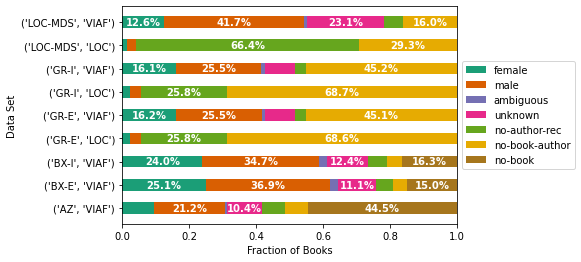

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender            female      male  ambiguous   unknown  unlinked
dataset source                                                   
AZ      VIAF    0.095036  0.211904   0.007520  0.104146  0.581393
BX-E    VIAF    0.251157  0.368603   0.026465  0.111426  0.242349
BX-I    VIAF    0.240024  0.346807   0.024222  0.123842  0.265105
GR-E    LOC     0.024667  0.031116   0.000093       NaN  0.944124
        VIAF    0.161917  0.255413   0.010258  0.088720  0.483691
GR-I    LOC     0.024479  0.030850   0.000093       NaN  0.944578
        VIAF    0.161074  0.254817   0.010203  0.089061  0.484845
LOC-MDS LOC     0.013897  0.029001   0.000064       NaN  0.957037
        VIAF    0.126102  0.416742   0.010106  0.230591  0.216459

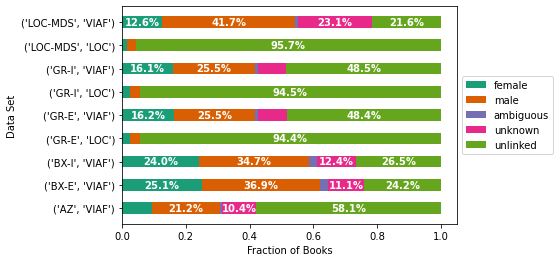

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

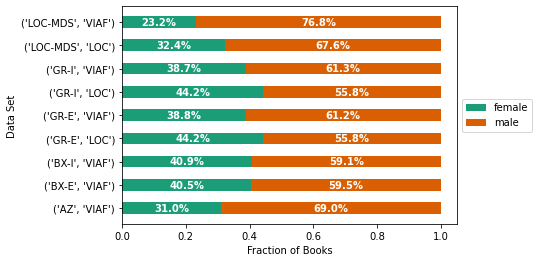

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender            female      male  ambiguous   unknown  no-author-rec  \
dataset source                                                           
AZ      VIAF    0.192064  0.291945   0.023830  0.092152       0.036091   
BX-E    VIAF    0.324906  0.433095   0.071250  0.064206       0.022849   
BX-I    VIAF    0.346719  0.413876   0.067528  0.068942       0.023258   
GR-E    LOC     0.202298  0.214581   0.014535       NaN       0.371755   
        VIAF    0.373811  0.388710   0.096451  0.041585       0.006924   
GR-I    LOC     0.178740  0.172871   0.009046       NaN       0.371474   
        VIAF    0.376147  0.362756   0.071403  0.051024       0.009104   

gender          no-book-author   no-book  
dataset source                            
AZ      VIAF          0.092607  0.271311  
BX-E    VIAF          0.021941  0.061753  
BX-I    VIAF          0.022721  0.056955  
GR-E    LOC           0.196832       NaN  
        VIAF          0.092518       NaN  
GR-I    LOC           0.267869       NaN  
        VIAF          0.129566       NaN

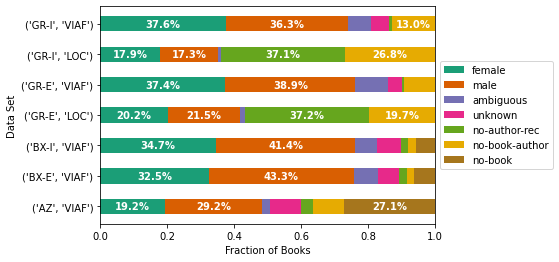

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender            female      male  ambiguous   unknown  unlinked
dataset source                                                   
AZ      VIAF    0.192064  0.291945   0.023830  0.092152  0.400009
BX-E    VIAF    0.324906  0.433095   0.071250  0.064206  0.106543
BX-I    VIAF    0.346719  0.413876   0.067528  0.068942  0.102935
GR-E    LOC     0.202298  0.214581   0.014535       NaN  0.568586
        VIAF    0.373811  0.388710   0.096451  0.041585  0.099442
GR-I    LOC     0.178740  0.172871   0.009046       NaN  0.639343
        VIAF    0.376147  0.362756   0.071403  0.051024  0.138670

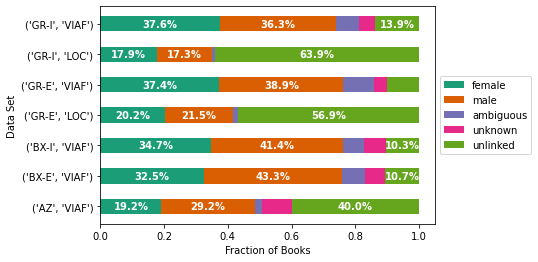

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

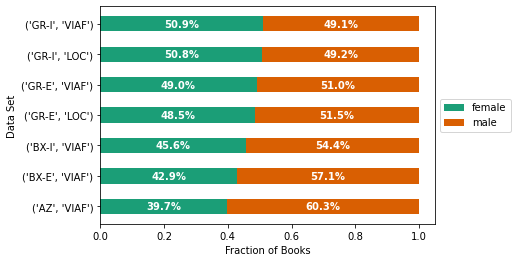

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))